# Episode 1: Intro to Raster Data, Bad Data Values, Summary Stats

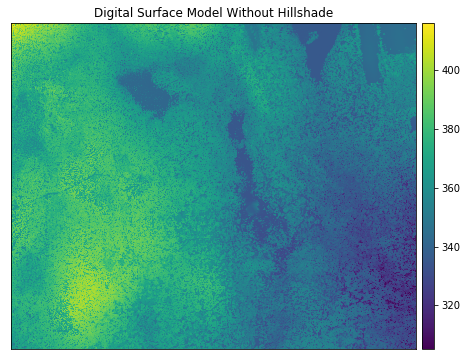

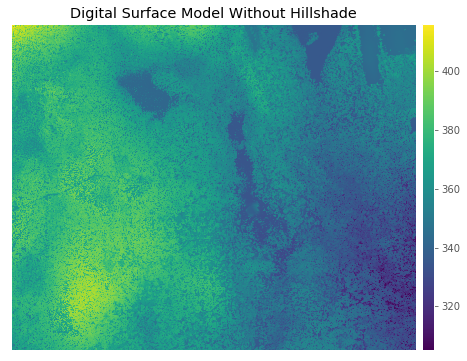

345.5899963378906
374.2799987792969


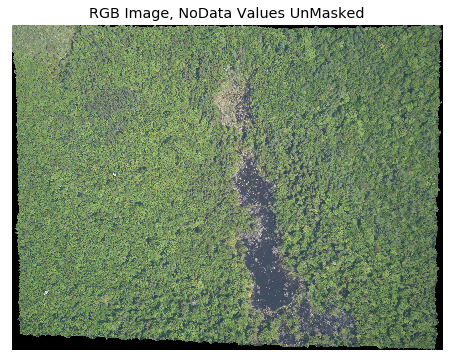

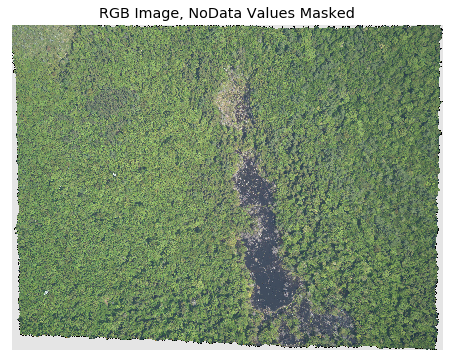

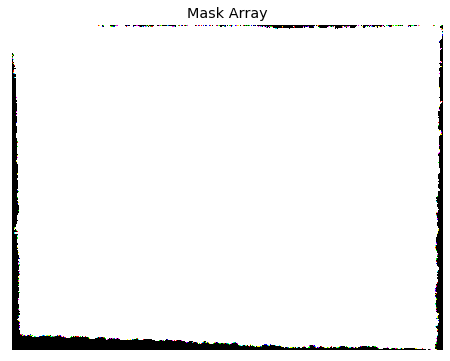

-3.4e+38
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4e+38, 'width': 1697, 'height': 1367, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(1.0, 0.0, 731453.0,
       0.0, -1.0, 4713838.0)}


In [1]:
import rasterio
import scipy.stats
import numpy
import earthpy.plot
import matplotlib.pyplot as plt

surface_model_HARV = rasterio.open("NEON-DS-Airborne-Remote-Sensing/HARV/DSM/HARV_dsmCrop.tif")
surface_model_HARV.meta

surface_model_HARV.meta['width']

surface_model_HARV_arr = surface_model_HARV.read(1)
surface_model_HARV.read(1)

earthpy.plot.plot_bands(
    surface_model_HARV_arr,
    scale=False,
    cmap="viridis",
    title="Digital Surface Model Without Hillshade",
    figsize=(10, 6)
)

plt.style.use("ggplot")
earthpy.plot.plot_bands(
     surface_model_HARV_arr,
     scale=False,
     cmap="viridis",
     title="Digital Surface Model Without Hillshade",
     figsize=(10, 6)
)

surface_model_HARV.crs

earthpy.epsg['32618']

scipy.stats.describe(surface_model_HARV_arr, axis=None)

print(numpy.percentile(surface_model_HARV_arr, 25))
print(numpy.percentile(surface_model_HARV_arr, 75))

surface_model_HARV.meta['count']

surface_model_HARV_arr_3D = surface_model_HARV.read()
surface_model_HARV_arr_3D.shape

surface_model_HARV_arr_2D = surface_model_HARV.read(1)
surface_model_HARV_arr_2D.shape

rgb_HARV = rasterio.open("NEON-DS-Airborne-Remote-Sensing/HARV/RGB_Imagery/HARV_RGB_Ortho.tif", "r")
rgb_HARV_arr = rgb_HARV.read()
earthpy.plot.plot_rgb(
    rgb_HARV_arr,
    title="RGB Image, NoData Values UnMasked",
    figsize=(10, 6)
)

rgb_HARV_masked_arr = numpy.ma.masked_where(rgb_HARV_arr==0, rgb_HARV_arr) #1st argument is the condition, second is the array to mask
earthpy.plot.plot_rgb(
    rgb_HARV_masked_arr,
    title="RGB Image, NoData Values Masked",
    figsize=(10, 6)
)

earthpy.plot.plot_rgb(
    rgb_HARV_masked_arr.mask*-1, # mutliplying a boolean array by -1 reverses True and False values
    title="Mask Array",
    figsize=(10, 6)
)

print(surface_model_HARV.nodata)
changed_meta_copy = surface_model_HARV.meta.copy()
changed_meta_copy['nodata'] = -3.4e+38
print(changed_meta_copy)


# Episode 2 Raster Reprojecting

In [2]:
import os
os.chdir("../")

In [3]:
from rasterio.warp import calculate_default_transform, reproject
import rasterio

surface_model_HARV = rasterio.open("data/NEON-DS-Airborne-Remote-Sensing/HARV/DSM/HARV_dsmCrop.tif")

terrain_model_HARV_WGS84 = rasterio.open("data/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_WGS84.tif")

In [4]:
import earthpy
earthpy.epsg["32618"]

'+proj=utm +zone=18 +datum=WGS84 +units=m +no_defs'

In [5]:
transform, width, height = calculate_default_transform(
    terrain_model_HARV_WGS84.crs, surface_model_HARV.crs, terrain_model_HARV_WGS84.width, terrain_model_HARV_WGS84.height, *terrain_model_HARV_WGS84.bounds)

In [6]:
destination_crs = surface_model_HARV.crs
reprojected_meta = terrain_model_HARV_WGS84.meta.copy()
reprojected_meta.update({
        'crs': destination_crs,
        'transform': transform,
        'width': width,
        'height': height
})

In [7]:
reprojected_path = "data/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_UTM18_rasterio.tif"
with rasterio.open(reprojected_path, "w", **reprojected_meta) as reprojected_data:
    reproject(
        source = rasterio.band(terrain_model_HARV_WGS84, 1), 
        destination = rasterio.band(reprojected_data, 1), 
        src_crs=terrain_model_HARV_WGS84.crs, 
        dst_crs=terrain_model_HARV_WGS84.crs)

In [8]:
reprojected_tif = rasterio.open(reprojected_path)
arr = reprojected_tif.read()

In [9]:
import xarray
import rioxarray

surface_model_HARV_xarr = xarray.open_rasterio("data/NEON-DS-Airborne-Remote-Sensing/HARV/DSM/HARV_dsmCrop.tif")
terrain_model_HARV_xarr_WGS84 = xarray.open_rasterio("data/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_WGS84.tif")

In [10]:
surface_model_HARV_xarr.compute()

<xarray.DataArray (band: 1, y: 1367, x: 1697)>
array([[[408.76998901, 408.22998047, 406.52999878, ..., 345.05999756,
         345.13998413, 344.97000122],
        [407.04998779, 406.61999512, 404.97998047, ..., 345.20999146,
         344.97000122, 345.13998413],
        [407.05999756, 406.02999878, 403.54998779, ..., 345.07000732,
         345.08999634, 345.17999268],
        ...,
        [367.91000366, 370.19000244, 370.58999634, ..., 311.38998413,
         310.44998169, 309.38998413],
        [370.75997925, 371.50997925, 363.41000366, ..., 314.70999146,
         309.25      , 312.01998901],
        [369.95999146, 372.6000061 , 372.42999268, ..., 316.38998413,
         309.86999512, 311.20999146]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.714e+06 4.714e+06 4.714e+06 ... 4.712e+06 4.712e+06
  * x        (x) float64 7.315e+05 7.315e+05 7.315e+05 ... 7.331e+05 7.331e+05
Attributes:
    transform:      (1.0, 0.0, 731453.0, 0.0, -1.0, 4713838.0)
    crs:            +init=epsg:32618
    res:            (1.0, 1.0)
    is_tiled:       0
    nodatavals:     (-3.4e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [11]:
terrain_model_HARV_xarr_WGS84.rio.nodata

-9999.0

In [12]:
reprojected = terrain_model_HARV_xarr_WGS84.rio.reproject(dst_crs=surface_model_HARV_xarr.rio.crs)

reprojected_path = "data/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_UTM18_rioxarray.tif"
reprojected.rio.to_raster(reprojected_path)

terrain_model_HARV_xarr_UTM18= xarray.open_rasterio(reprojected_path)

In [13]:
arr.shape

(1, 1492, 1801)

In [14]:
surface_model_HARV_xarr.rio.nodata

-3.4e+38

In [15]:
surface_model_HARV_xarr.shape

(1, 1367, 1697)

In [16]:
(terrain_model_HARV_xarr_UTM18 == arr).all()

<xarray.DataArray ()>
array(True)

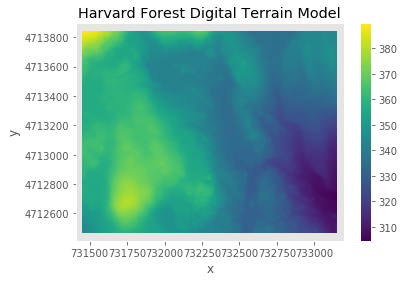

In [24]:
import matplotlib.pyplot as plt
terrain_model_HARV_xarr_UTM18.where(
    terrain_model_HARV_xarr_UTM18!=terrain_model_HARV_xarr_UTM18.rio.nodata).plot(cmap="viridis")
plt.title("Harvard Forest Digital Terrain Model")
plt.savefig("fig/02-HARV-reprojected-DTM-01.png")

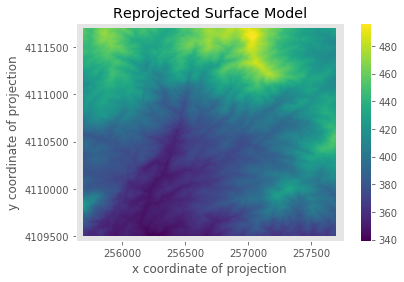

In [25]:
import xarray
import rioxarray
import matplotlib.pyplot as plt

terrain_model_HARV_SJER = xarray.open_rasterio("data/NEON-DS-Airborne-Remote-Sensing/SJER/DTM/SJER_dtmCrop.tif")
surface_model_HARV_SJER = xarray.open_rasterio("data/NEON-DS-Airborne-Remote-Sensing/SJER/DSM/SJER_dsmCrop_WGS84.tif")

reprojected_surface_model = surface_model_HARV_SJER.rio.reproject(dst_crs=terrain_model_HARV_SJER.rio.crs)
reprojected_surface_model.rio.to_raster("data/NEON-DS-Airborne-Remote-Sensing/SJER/DSM/SJER_dsmCrop_WGS84.tif")

reprojected_surface_model.where(reprojected_surface_model != reprojected_surface_model.rio.nodata).plot()
plt.title("Reprojected Surface Model")
plt.savefig("fig/02-SJER-DSM-02.png")

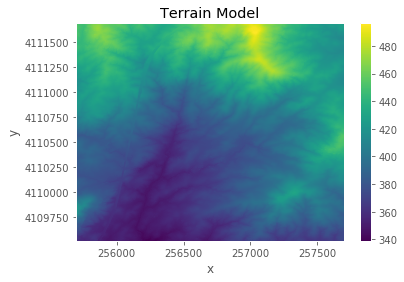

In [26]:
terrain_model_HARV_SJER.where(terrain_model_HARV_SJER != terrain_model_HARV_SJER.rio.nodata).plot()
plt.title("Terrain Model")
plt.savefig("fig/02-SJER-DTM-03.png")

In [22]:
terrain_model_HARV_SJER.shape

(1, 2178, 2005)

In [23]:
surface_model_HARV_SJER.shape

(1, 2280, 2118)